In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
from matplotlib import cm

from importlib import reload
import datetime
from sklearn import preprocessing,metrics,model_selection
import missingno as msn
from functools import reduce

from pymer4.models import Lmer
from pymer4.io import save_model, load_model
from sklmer import LmerRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


from importlib import reload
import sys
sys.path.insert(1,'../scripts')
sys.path.insert(1,'..')
import plots
import predict_regress
import _preprocess
import os
import re
from _thresholds import BEHAVIORAL_INFO

In [8]:
covs = ['time_since_diagnosis','diagnosis_age','education','male']
clinical_t = ['updrs_ii','updrs_iii_ON','updrs_iii_OFF','updrs_iv','semantic_fluency', 'moca', 'benton',
       'lns', 'hvlt_recall', 'hvlt_recognition', 'hvlt_retention',
       'symbol_digit', 'stai_trait', 'stai_state', 'gds', 'quip',
       'epworth', 'rbd', 'systolic_bp_drop', 'scopa_aut',
       'updrs_i','se_adl']
datscan_t =['datscan_mean','datscan_asymmetry','datscan_putamen_mean',
           'datscan_caudate_mean','datscan_caudate_asymmetry','datscan_putamen_asymmetry']
bio_t =['ptau','ttau','abeta','alphasynuclein','gfap','nfl']
ledd_t =['LEDD']

cl_names = np.array(['UPDRS II','UPDRS III ON','UPDRS III OFF','UPDRS IV','Semantic Fluency', 'MOCA', 'Benton',
       'Letter Number Sequencing', 'HVLT Recall', 'HVLT Recognition', 'HVLT Retention',
       'Symbol Digit', 'STAI trait', 'STAI state', 'GDS', 'QUIP',
       'Epworth Sleepiness', 'RBDSQ', 'Systolic BP Drop', 'SCOPA autonome',
       'UPDRS I','Schwab England ADL','LEDD','SBR mean','SBR asymmetry','putamen mean',
           'caudate mean','caudate asymmetry','putamen asymmetry','ptau','ttau','abeta','alphasynuclein','gfap','nfl'])

In [2]:
# load raw visit data
path = '/scratch/c.c21013066/data/ppmi/'
demo = pd.read_csv(f'{path}phenotypes2021/demographics_clean.csv',parse_dates=['date_birth','date_diagnosis'])
demo['diagnosis_age'] = (demo['date_diagnosis'] - demo['date_birth']) / np.timedelta64(1,'Y')

data = pd.read_csv('/scratch/c.c21013066/data/ppmi/phenotypes2021/clinical_progression_raw_clean.csv',parse_dates=['date','date_diagnosis'])
data = data[data['diagnosis']=='pd']
clinicalhc = pd.read_csv('/scratch/c.c21013066/data/ppmi/phenotypes2021/clinical_progression_raw_clean_HC.csv',parse_dates=['date','date_diagnosis'])
data_clean = data.dropna(subset=['education'])
data_clean = data_clean.rename(columns={'gender':'male'})

datscanraw=pd.read_csv('/scratch/c.c21013066/data/ppmi/phenotypes2021/datscan_clean.csv',parse_dates=['date'])
datscanraw = pd.merge(datscanraw,demo,on='participant',how='outer')
datscanraw = datscanraw.dropna(subset=['datscan_caudate_l','education'],how='any')
n_visit = datscanraw.groupby('participant').size().rename('n_visits')
datscanraw = pd.merge(datscanraw,n_visit,on='participant')
#datscan = datscan[datscan['n_visit']>=2]
datscanraw['male'] = datscanraw['gender'].replace(['f','m'],[0,1])
#datscan = datscan[datscan['participant'].isin(merged_clean.participant)]
datscanraw = _preprocess.get_DatScan_IDPs(datscanraw)
datscan = datscanraw[datscanraw['diagnosis']=='pd']
datscanhc = datscanraw[datscanraw['diagnosis']=='hc']
datscan = _preprocess.get_visit_age(datscan)
datscan['time_since_diagnosis'] = datscan['visit_age'] - datscan['diagnosis_age']

bioraw=pd.read_csv('/scratch/c.c21013066/data/ppmi/phenotypes2021/biospecimen_clean_add.csv',parse_dates=['date'])
bioraw = pd.merge(bioraw,demo,on='participant',how='outer')
bioraw = bioraw.dropna(subset=['ptau','ttau','abeta_1-42','csf_alpha-synuclein','gfap','nfl'],how='all').dropna(subset=['education'],how='any')
n_visit = bioraw.groupby('participant').size().rename('n_visits')
bioraw = pd.merge(bioraw,n_visit,on='participant')
#bio = bio[bio['n_visit']>=2]
bioraw['male'] = bioraw['gender'].replace(['f','m'],[0,1])
bioraw = bioraw.rename(columns={'abeta_1-42':'abeta','csf_alpha-synuclein':'alphasynuclein'})
bio = bioraw[bioraw['diagnosis']=='pd']
biohc=bioraw[bioraw['diagnosis']=='hc']
bio = _preprocess.get_visit_age(bio)
bio['time_since_diagnosis'] = bio['visit_age'] - bio['diagnosis_age']

ledd = pd.read_csv(f'{path}/phenotypes2021/ledd.csv',parse_dates=['date'],index_col=0)
ledd = pd.merge(ledd,demo,on='participant',how='outer')
ledd = ledd[ledd['diagnosis']=='pd']
ledd = ledd.dropna(subset=['LEDD'],how='all').dropna(subset=['education'],how='any')
n_visit = ledd.groupby('participant').size().rename('n_visits')
ledd = pd.merge(ledd,n_visit,on='participant')
#bio = bio[bio['n_visit']>=2]
ledd['male'] = ledd['gender'].replace(['f','m'],[0,1])
ledd = _preprocess.get_visit_age(ledd)
ledd['time_since_diagnosis'] = ledd['visit_age'] - ledd['diagnosis_age']
ledd = ledd.drop_duplicates(subset=['participant','date','LEDD'])

../_preprocess.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['visit_age'] = (df['date'] - df['date_birth']) / np.timedelta64(1,'Y')
<ipython-input-2-a57d68b0bce4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datscan['time_since_diagnosis'] = datscan['visit_age'] - datscan['diagnosis_age']
../_preprocess.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

# Change over time

In [44]:
# plot difference in UPDRS III over time

# Custom function to compute the difference by skipping NaN values
def compute_diff(series):
    valid_values = series.dropna()
    return valid_values.diff()
# Loop over the columns
for col in clinical_t:
    diff_col_name = f'{col}_Diff'
    data_clean[diff_col_name] = data_clean.groupby('participant')[col].apply(compute_diff).reset_index(level=0, drop=True)
    
    # Compute time difference for valid (non-NaN) entries in the current column
    time_diff_col_name = f'{col}_TimeDiff'
    data_clean[time_diff_col_name] = data_clean.groupby('participant')['time_since_diagnosis'].apply(lambda x: x.diff().where(data_clean[col].notna())).reset_index(level=0, drop=True)

    # Compute yearly rate
    yearly_rate_col_name = f'{col}_YearlyRate'
    data_clean[yearly_rate_col_name] = data_clean[diff_col_name] / data_clean[time_diff_col_name]


In [33]:
data_clean[[f'{c}_ffill' for c in clinical_t]] = data_clean.groupby('participant')[clinical_t].fillna(method='ffill')

# Compute difference in filled values
data_clean[[f'{c}_diff_ffill' for c in clinical_t]] = data_clean.groupby('participant')[[f'{c}_ffill' for c in clinical_t]].diff()

# Compute time difference
data_clean['TimeDiff'] = data_clean.groupby('participant')['time_since_diagnosis'].diff()

for c in clinical_t:
    col_name = f'{c}_diff_ffill'
    data_clean[col_name] = data_clean[col_name] / data_clean['TimeDiff']

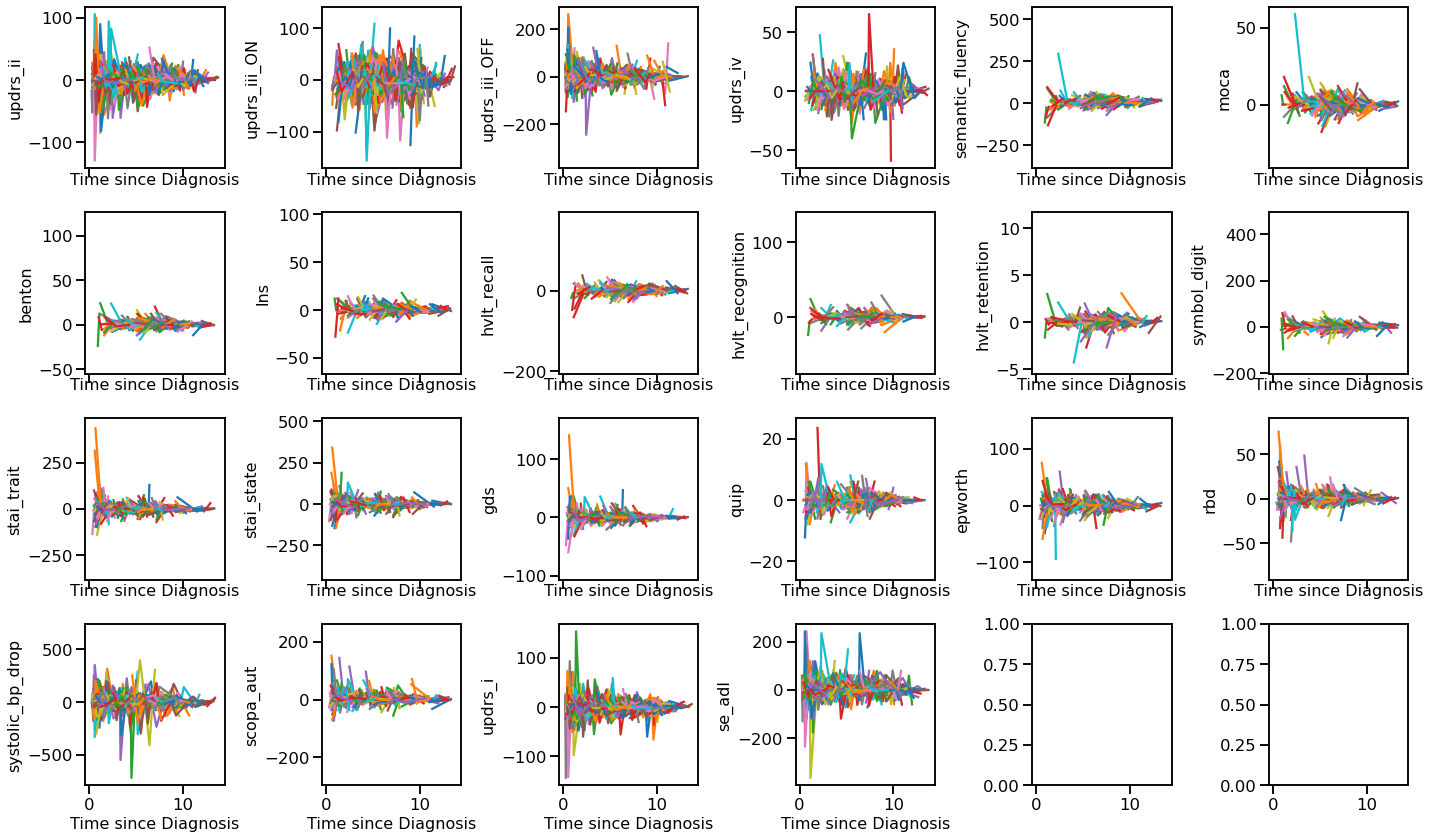

In [66]:
fig,axes = plt.subplots(figsize=(20,12),nrows=4,ncols=6,sharex=True)
plots.plot_context()
for ax,col in zip(axes.flatten(),clinical_t):
    for patient, group in data_clean.groupby('participant'):
        ax.plot(group['time_since_diagnosis'], group[f'{col}_YearlyRate'])

    ax.set_xlabel('Time since Diagnosis')
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()

In [54]:
statistics = pd.DataFrame(columns=['r','p'],index=clinical_t)
for col in clinical_t:
    nona = data_clean.dropna(subset=[col,'time_since_diagnosis'])
    r,p = stats.pearsonr(nona[col],nona['time_since_diagnosis'])
    statistics.loc[col,'r'] = r
    statistics.loc[col,'p'] = p
statistics

# Extract slope and intercept with linear mixed model

In [5]:
# select only after medication dates
clmed = pd.merge(data_clean,ledd,on=['participant','date'],suffixes=['','_drop£'],how='outer')
clmed = clmed.drop(columns=clmed.filter(regex='_drop£').columns)
clmed = clmed.dropna(subset=['time_since_diagnosis'])
clmed['LEDD_gt_0'] = clmed['LEDD'] > 0
clmed['cumulative_LEDD_gt_0'] = clmed.groupby('participant')['LEDD_gt_0'].cumsum()
clmed['max_cumulative_LEDD_gt_0'] = clmed.groupby('participant')['cumulative_LEDD_gt_0'].cummax()
filtered_clmed = clmed[clmed['max_cumulative_LEDD_gt_0'] > 0]
first_med = filtered_clmed.groupby('participant')['time_since_diagnosis'].first().rename('first_medication')
filtered_clmed = pd.merge(filtered_clmed,first_med,on=['participant'],how='outer')
filtered_clmed['time_since_medication'] = filtered_clmed['time_since_diagnosis'] - filtered_clmed['first_medication']

In [6]:
# random: participant,time
modelsall = []
for k,kind in enumerate(['linear','squared','cubic']):
    for s,scale in enumerate([True,False]):
        #for (i,data),targets in zip(enumerate([filtered_clmed]),[['updrs_iii_ON','updrs_iii_OFF','updrs_iv','LEDD']]):
        for (i,data),targets in zip(enumerate([data_clean,ledd,datscan,bio]),[clinical_t,ledd_t,datscan_t,bio_t]):
            data_un = data.sort_values(['participant','time_since_diagnosis'])
            data_un = data_un[data_un['diagnosis'].isin(['pd'])]
            print(data_un.shape,data.shape)
            if i==0:
                data_rate_slope = data_un.groupby('participant').first()[np.hstack([covs,'time_since_diagnosis','date'])]
                data_rate_slope_diff = data_rate_slope.copy(deep=True)
                models = []
                AIC = pd.DataFrame(columns=['AIC'])
            for target in targets:
                data_tar = data_un.dropna(subset=[target,'education','diagnosis_age','male'],how='any',axis='rows')
                print("only visits where data available",data_tar.shape,len(np.unique(data_tar.participant)))
                n_visits = data_tar.groupby('participant').size().rename('n_visits')
                data_tar = pd.merge(data_tar,n_visits,on='participant',suffixes=['_drop£',''])
                data_tar = data_tar.drop(columns=['n_visits_drop£'])
                data_tar = data_tar[data_tar['n_visits']>=2]
                data_tar = data_tar.sort_values(['participant','time_since_diagnosis'])
                if scale:
                    data_tar[np.hstack([['education','diagnosis_age'],targets])] = preprocessing.StandardScaler().fit_transform(data_tar[np.hstack([['education',
                                                                                                                'diagnosis_age'],targets])])
                else:
                    data_tar[np.hstack([['education','diagnosis_age']])] = preprocessing.StandardScaler().fit_transform(data_tar[np.hstack([['education',
                                                                                                                'diagnosis_age']])])
                if s==0 and k==0:
                    data_tar.to_csv(f'/scratch/c.c21013066/data/ppmi/phenotypes/progression_scaled_{target}.csv')
                print("need at least 2 visits",data_tar.shape,len(np.unique(data_tar.participant)))

                #poly
                if kind=='linear':
                    md = Lmer(f"{target} ~ time_since_diagnosis + education + diagnosis_age + male + (time_since_diagnosis|participant)", data = data_tar)
                elif kind=='squared':
                    md = Lmer(f"{target} ~ poly(time_since_diagnosis,2) + education + diagnosis_age + male + (poly(time_since_diagnosis,2)|participant)", data = data_tar)
                elif kind=='cubic':
                    md = Lmer(f"{target} ~ poly(time_since_diagnosis,3) + education + diagnosis_age + male + (poly(time_since_diagnosis,3)|participant)", data = data_tar)
                try:
                    md.fit()
                    models.append(md)
                    AIC.loc[target,'AIC'] = md.AIC
                    data_intercept_tar_diff = pd.DataFrame(md.ranef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                    if kind=='linear':
                        data_rate_tar_diff = pd.DataFrame(md.ranef['time_since_diagnosis'].values,columns=[f'{target}_slope'],index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef['time_since_diagnosis'].values,columns=[f'{target}_slope'],index=np.unique(data_tar.participant))
                    elif kind=='squared':
                        data_rate_tar_diff = pd.DataFrame(md.ranef[['poly(time_since_diagnosis, 2)1',
                                                                   'poly(time_since_diagnosis, 2)2']].values,columns=[f'{target}_slope1',f'{target}_slope2'],index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef[['poly(time_since_diagnosis, 2)1',
                                                                   'poly(time_since_diagnosis, 2)2']].values,columns=[f'{target}_slope1',f'{target}_slope2'],index=np.unique(data_tar.participant))
                    elif kind=='cubic':
                        data_rate_tar_diff = pd.DataFrame(md.ranef[['poly(time_since_diagnosis, 3)1',
                                                                   'poly(time_since_diagnosis, 3)2',
                                                                   'poly(time_since_diagnosis, 3)3']].values,columns=[f'{target}_slope1',f'{target}_slope2',f'{target}_slope3'],
                                                          index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef[['poly(time_since_diagnosis, 3)1',
                                                                   'poly(time_since_diagnosis, 3)2',
                                                                   'poly(time_since_diagnosis, 3)3']].values,columns=[f'{target}_slope1',f'{target}_slope2',f'{target}_slope3'],
                                                     index=np.unique(data_tar.participant))
        #             if scale:
        #                 save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{target}.csv')
        #             else:
        #                 save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{target}_notscaled.csv')
                except:
                    print('not enough data for ',target)
                    models.append([])
                data_rate_slope_diff = data_rate_slope_diff.merge(data_intercept_tar_diff,right_index=True,left_index=True,how='outer')
                data_rate_slope_diff = data_rate_slope_diff.merge(data_rate_tar_diff,right_index=True,left_index=True,how='outer') 
                data_rate_slope = data_rate_slope.merge(data_intercept_tar,right_index=True,left_index=True,how='outer')
                data_rate_slope = data_rate_slope.merge(data_rate_tar,right_index=True,left_index=True,how='outer')
        if scale:
            data_rate_slope_diff.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/randomeffects.csv')
            data_rate_slope.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects.csv')
            AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC.csv')
        else:
            data_rate_slope_diff.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/randomeffects_notscaled.csv')
            data_rate_slope.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_notscaled.csv')
            AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC_notscaled.csv')
        modelsall.append(models)

(7536, 53) (7536, 53)
only visits where data available (7497, 53) 665
need at least 2 visits (7496, 53) 664
Formula: updrs_ii~time_since_diagnosis+education+diagnosis_age+male+(time_since_diagnosis|participant)

Family: gaussian	 Inference: parametric

Number of observations: 7496	 Groups: {'participant': 664.0}

Log-likelihood: -6867.532 	 AIC: 13735.064

Random effects:

                             Name    Var    Std
participant           (Intercept)  0.427  0.653
participant  time_since_diagnosis  0.025  0.157
Residual                           0.243  0.493

                     IV1                   IV2   Corr
participant  (Intercept)  time_since_diagnosis -0.229

Fixed effects:

only visits where data available (4406, 53) 630
need at least 2 visits (4376, 53) 600
Model failed to converge with max|grad| = 0.0022582 (tol = 0.002, component 1) 

Formula: updrs_iii_ON~time_since_diagnosis+education+diagnosis_age+male+(time_since_diagnosis|participant)

Family: gaussian	 Inference: pa

In [177]:
for md,t in zip(models,np.hstack([clinical_t,datscan_t,bio_t])):
            if scale:
                save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{t}.h5')
            else:
                save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{t}_notscaled.h5')

RRuntimeError: Error in gzfile(file, mode) : cannot open the connection


In [308]:
AIC = pd.DataFrame(columns=['AIC'],index=np.hstack([clinical_t,datscan_t,bio_t]))
r2 = pd.DataFrame(columns=['r2'],index=np.hstack([clinical_t,datscan_t,bio_t]))
kind='linear'
scale=True
for md,c in zip(modelsscaled,np.hstack([clinical_t,datscan_t,bio_t])):
    try:
        AIC.loc[c,'AIC'] = md.AIC
        r2.loc[c,'r2'] = md.r2
    except:
        print(c)
if scale:
    AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC.csv')
    r2.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/r2.csv')
else:
    AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC_notscaled.csv')
    r2.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/r2_notscaled.csv')

updrs_ii
updrs_iii_ON
updrs_iii_OFF
updrs_iv
semantic_fluency
moca
benton
lns
hvlt_recall
hvlt_recognition
hvlt_retention
symbol_digit
stai_trait
stai_state
gds
quip
epworth
rbd
systolic_bp_drop
scopa_aut
updrs_i
se_adl
datscan_mean
datscan_asymmetry
datscan_putamen_mean
datscan_caudate_mean
datscan_caudate_asymmetry
datscan_putamen_asymmetry
ptau
ttau
abeta
alphasynuclein


## model as time since medication

In [7]:
# medication models: align at first medication
modelsmed = []
covs = ['time_since_medication','education','diagnosis_age','first_medication','male']
for kind in ['linear','squared','cubic']:
    for scale in [True,False]:
        for (i,data),targets in zip(enumerate([filtered_clmed]),[['updrs_iii_ON','updrs_iii_OFF','updrs_iv','LEDD']]):
        #for (i,data),targets in zip(enumerate([data_clean,ledd,datscan,bio]),[clinical_t,ledd_t,datscan_t,bio_t]):
            data_un = data.sort_values(['participant','time_since_medication'])
            data_un = data_un[data_un['diagnosis'].isin(['pd'])]
            print(data_un.shape,data.shape)
            if i==0:
                data_rate_slope = data_un.groupby('participant').first()[np.hstack([covs,'date'])]
                data_rate_slope_diff = data_rate_slope.copy(deep=True)
                models = []
                AIC = pd.DataFrame(columns=['AIC'])
            for target in targets:
                data_tar = data_un.dropna(subset=[target,'education','diagnosis_age','male','time_since_medication','first_medication'],how='any',axis='rows')
                print("only visits where data available",data_tar.shape,len(np.unique(data_tar.participant)))
                n_visits = data_tar.groupby('participant').size().rename('n_visits')
                data_tar = pd.merge(data_tar,n_visits,on='participant',suffixes=['_drop£',''])
                data_tar = data_tar.drop(columns=['n_visits_drop£'])
                data_tar = data_tar[data_tar['n_visits']>=2]
                data_tar = data_tar.sort_values(['participant','time_since_medication'])
                if scale:
                    data_tar[np.hstack([['education','diagnosis_age','first_medication'],targets])] = preprocessing.StandardScaler().fit_transform(data_tar[np.hstack([['education',
                                                                                                                'diagnosis_age','first_medication'],targets])])
                else:
                    data_tar[np.hstack([['education','diagnosis_age','first_medication']])] = preprocessing.StandardScaler().fit_transform(data_tar[np.hstack([['education',
                                                                                                                'diagnosis_age','first_medication']])])
                    if i==0:
                        data_tar.to_csv(f'/scratch/c.c21013066/data/ppmi/phenotypes/progression_scaled_{target}_medfiltered.csv')
                print("need at least 2 visits",data_tar.shape,len(np.unique(data_tar.participant)))

                #quadratic
                if kind=='linear':
                    md = Lmer(f"{target} ~ time_since_medication + education + diagnosis_age + male + first_medication + (time_since_medication|participant)", data = data_tar)
                elif kind=='squared':
                    md = Lmer(f"{target} ~ poly(time_since_medication,2) + education + diagnosis_age + male + first_medication + (poly(time_since_medication,2)|participant)", data = data_tar)
                elif kind=='cubic':
                    md = Lmer(f"{target} ~ poly(time_since_medication,3) + education + diagnosis_age + male + first_medication + (poly(time_since_medication,3)|participant)", data = data_tar)
                try:
                    md.fit()
                    models.append(md)
                    AIC.loc[target,'AIC'] = md.AIC
                    data_intercept_tar_diff = pd.DataFrame(md.ranef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                    if kind=='linear':
                        data_rate_tar_diff = pd.DataFrame(md.ranef['time_since_medication'].values,columns=[f'{target}_slope'],index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef['time_since_medication'].values,columns=[f'{target}_slope'],index=np.unique(data_tar.participant))
                    elif kind=='squared':
                        data_rate_tar_diff = pd.DataFrame(md.ranef[['poly(time_since_medication, 2)1',
                                                                   'poly(time_since_medication, 2)2']].values,columns=[f'{target}_slope1',f'{target}_slope2'],index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef[['poly(time_since_medication, 2)1',
                                                                   'poly(time_since_medication, 2)2']].values,columns=[f'{target}_slope1',f'{target}_slope2'],index=np.unique(data_tar.participant))
                    elif kind=='cubic':
                        data_rate_tar_diff = pd.DataFrame(md.ranef[['poly(time_since_medication, 3)1',
                                                                   'poly(time_since_medication, 3)2',
                                                                   'poly(time_since_medication, 3)3']].values,columns=[f'{target}_slope1',f'{target}_slope2',f'{target}_slope3'],
                                                          index=np.unique(data_tar.participant))
                        data_intercept_tar = pd.DataFrame(md.fixef['(Intercept)'].values,columns=[f'{target}_intercept'],index=np.unique(data_tar.participant))
                        data_rate_tar = pd.DataFrame(md.fixef[['poly(time_since_medication, 3)1',
                                                                   'poly(time_since_medication, 3)2',
                                                                   'poly(time_since_medication, 3)3']].values,columns=[f'{target}_slope1',f'{target}_slope2',f'{target}_slope3'],
                                                     index=np.unique(data_tar.participant))
        #             if scale:
        #                 save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{target}.csv')
        #             else:
        #                 save_model(md, f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/{target}_notscaled.csv')
                except:
                    print('not enough data for ',target)
                    models.append([])
                data_rate_slope_diff = data_rate_slope_diff.merge(data_intercept_tar_diff,right_index=True,left_index=True,how='outer')
                data_rate_slope_diff = data_rate_slope_diff.merge(data_rate_tar_diff,right_index=True,left_index=True,how='outer') 
                data_rate_slope = data_rate_slope.merge(data_intercept_tar,right_index=True,left_index=True,how='outer')
                data_rate_slope = data_rate_slope.merge(data_rate_tar,right_index=True,left_index=True,how='outer')
        if scale:
            data_rate_slope_diff.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/randomeffects_medfiltered.csv')
            data_rate_slope.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_medfiltered.csv')
            AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC_medfiltered.csv')
        else:
            data_rate_slope_diff.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/randomeffects_notscaled_medfiltered.csv')
            data_rate_slope.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_notscaled_medfiltered.csv')
            AIC.to_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/AIC_notscaled_medfiltered.csv')
        modelsmed.append(models)

(5762, 72) (5762, 72)
only visits where data available (4378, 72) 627
need at least 2 visits (4345, 72) 594
Formula: updrs_iii_ON~time_since_medication+education+diagnosis_age+male+first_medication+(time_since_medication|participant)

Family: gaussian	 Inference: parametric

Number of observations: 4345	 Groups: {'participant': 594.0}

Log-likelihood: -4732.923 	 AIC: 9465.845

Random effects:

                              Name    Var    Std
participant            (Intercept)  0.566  0.752
participant  time_since_medication  0.028  0.168
Residual                            0.316  0.562

                     IV1                    IV2   Corr
participant  (Intercept)  time_since_medication -0.247

Fixed effects:

only visits where data available (3267, 72) 620
need at least 2 visits (3197, 72) 550
Formula: updrs_iii_OFF~time_since_medication+education+diagnosis_age+male+first_medication+(time_since_medication|participant)

Family: gaussian	 Inference: parametric

Number of observations: